In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
from PIL import Image
from google.colab import drive
#print(os.listdir("../drive/MyDrive"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/HAM10000_ZIPPED.zip > /dev/null

In [ ]:
#change of var name -> 2

skin_dir = '/content/HAM10000_unzipped'
img_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(skin_dir,'*', '*.jpg'))}
print(img_path_dict)

{'ISIC_0033603': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0033603.jpg', 'ISIC_0033222': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0033222.jpg', 'ISIC_0033798': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0033798.jpg', 'ISIC_0031217': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0031217.jpg', 'ISIC_0032464': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0032464.jpg', 'ISIC_0030930': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0030930.jpg', 'ISIC_0030622': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0030622.jpg', 'ISIC_0032024': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0032024.jpg', 'ISIC_0031202': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0031202.jpg', 'ISIC_0033150': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0033150.jpg', 'ISIC_0033399': '/content/HAM10000_unzipped/HAM10000_images_part_2/ISIC_0033399.jpg', 'ISIC_0029908': '/content/HAM10000_unzipped/HAM10000_

We created a dictionary for abbreviated labels for the diseases

In [ ]:
#change of var name -> 1
#Dict created for proper matching abbrv. with the dataset

lesion_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_class_dict = {
    0 : 'nv',
    1 : 'mel',
    2 : 'bkl',
    3 : 'bcc',
    4 : 'akiec',
    5 : 'vasc',
    6 : 'df',
    
}

Added columns for better readability

In [ ]:
skin_df = pd.read_csv('/content/HAM10000_unzipped/HAM10000_metadata.csv')

# Creating New Columns for better readability

skin_df['Path'] = skin_df['image_id'].map(img_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2


In [ ]:
skin_df['Path'][2]

'/content/HAM10000_unzipped/HAM10000_images_part_1/ISIC_0026769.jpg'

In [ ]:
skin_df['dx_type'].unique()

array(['histo', 'consensus', 'confocal', 'follow_up'], dtype=object)

In [ ]:
print(skin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   Path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB
None


In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
Path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
#Since only 'age' attribute has null values with a count of 57
#Filling it with their mean

skin_df['age'].fillna((skin_df['age'].mean()), inplace = True)

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
Path             0
cell_type        0
cell_type_idx    0
dtype: int64

# **EDA**
The following is the EDA section where we analyse the data of the datset for further processin and information gathering.

1. In the first graph we show the cell type counts for the different diseases.

In [ ]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

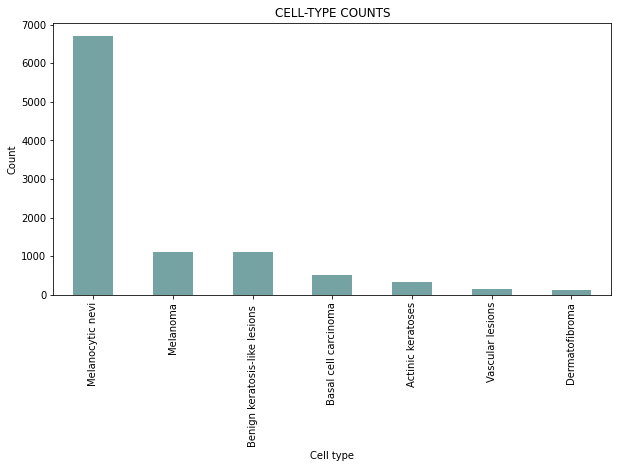

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1, color = (0.1, 0.4, 0.4, 0.6))
plt.title('CELL-TYPE COUNTS')
plt.xlabel('Cell type')
plt.ylabel('Count')
#addlabels(x, y)
plt.show()



*   #### According to this graph, Melanocytic nevi is majority in number in the given dataset 
* #### Melanoma type of cell has second highest count in the dataset.



2. In the next graph we show where the disease cells are located in all the dataset

In [ ]:
# skin_df['localization'].value_counts().plot(kind='bar',color = (0.5, 0.4, 0.7, 0.6))
# plt.title('LOCALIZATION COUNT')
# plt.xlabel('Location of disease')
# plt.ylabel('Count')
# plt.show()

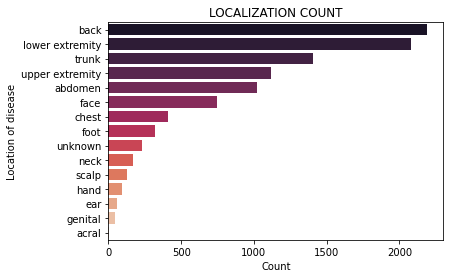

In [ ]:
ax=sns.countplot(data=skin_df, y='localization', order=skin_df.localization.value_counts().index, palette = "rocket")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('LOCALIZATION COUNT')
plt.ylabel('Location of disease')
plt.xlabel('Count')
plt.show()

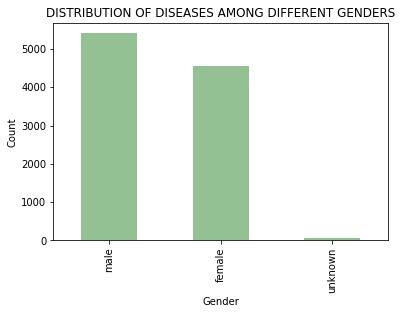

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar', color = (0.3, 0.6, 0.3, 0.6))
plt.title('DISTRIBUTION OF DISEASES AMONG DIFFERENT GENDERS')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

3. This graph shows us the different age groups which have been affected by the skin diseases

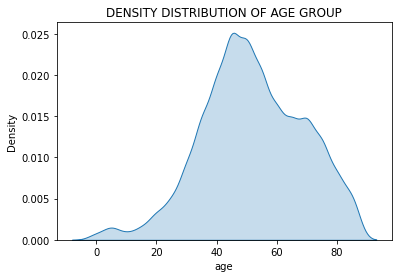

In [ ]:
sns.kdeplot(skin_df['age'], shade = True)
plt.title('DENSITY DISTRIBUTION OF AGE GROUP')
plt.show()

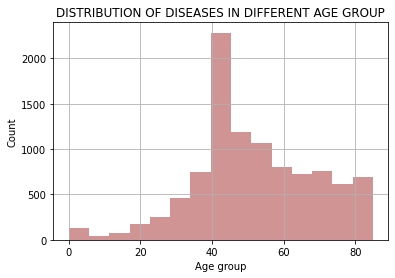

In [ ]:
skin_df['age'].hist(bins=15, color = (0.7, 0.3, 0.3, 0.6))
plt.title('DISTRIBUTION OF DISEASES IN DIFFERENT AGE GROUP')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

4. Information on the different genders who have been affected by the disases

5. This scatterplot gives us the distribution of the cell types among the various age groups

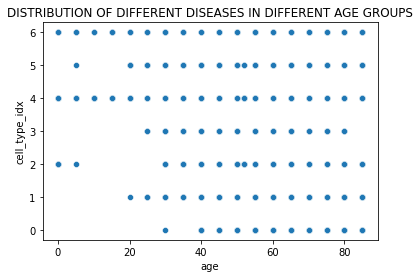

In [ ]:
#Visualization of different diseases among different age groups
sns.scatterplot(x=skin_df['age'], y = skin_df['cell_type_idx'], palette = 'icefire')
plt.title('DISTRIBUTION OF DIFFERENT DISEASES IN DIFFERENT AGE GROUPS')
plt.show()

6. This graph tells us where the diseases are located

7. The following plot gives us the count of cells of every disease in different parts of the body.

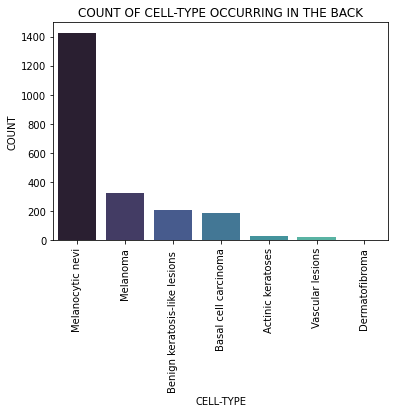

In [ ]:
local = skin_df[skin_df['localization']=='back']
ax=sns.countplot(data=local, x='cell_type', order = local.cell_type.value_counts().index, palette = "mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('COUNT OF CELL-TYPE OCCURRING IN THE BACK')
plt.xlabel('CELL-TYPE')
plt.ylabel('COUNT')
plt.show()


In [ ]:
# #diseases occuring in back portion of the body
# local_df = skin_df[skin_df['localization']=='back']
# local_df['cell_type'].value_counts().plot(kind='bar',color = (0.5, 0.9, 0.7, 0.6))
# local_df.head()
# plt.show()

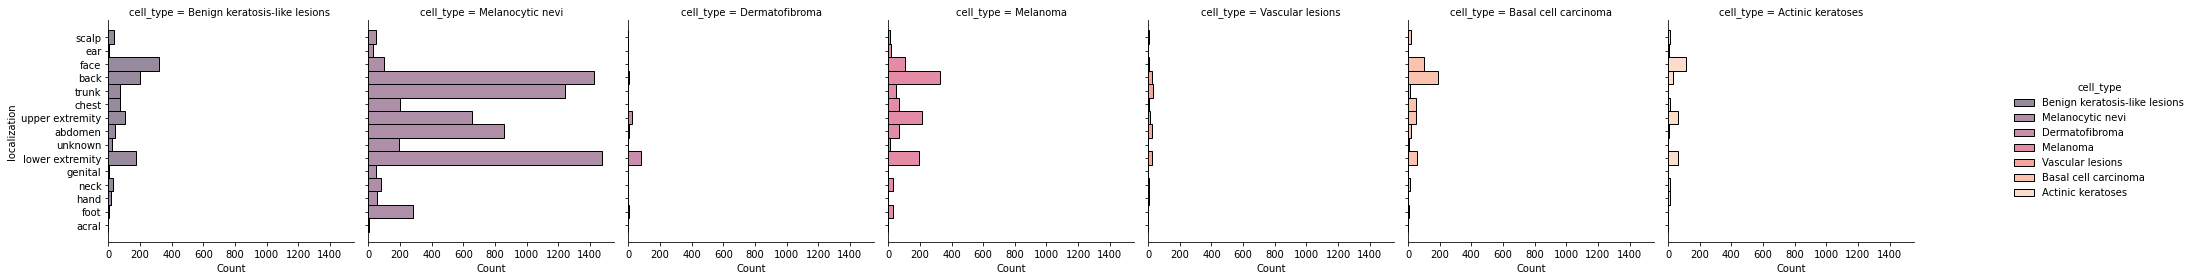

In [ ]:
ax = sns.displot(
    skin_df, y="localization", col="cell_type",
    height=4, binwidth = 1, facet_kws=dict(margin_titles=True), hue = 'cell_type',palette = 'rocket' )
#plt.xticks(rotation=90)
plt.show()

8. Distribution of different diseases across different genders

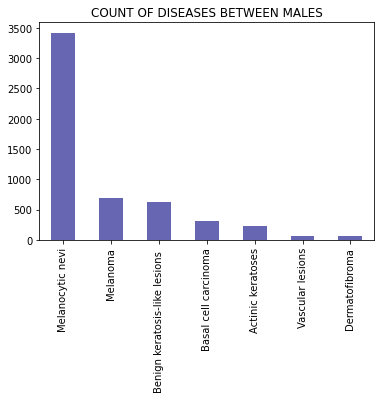

In [ ]:
#distribution of diseases b/w males

male_df = skin_df[skin_df['sex']=='male']
male_df['cell_type'].value_counts().plot(kind='bar',color = (0.0, 0.0, 0.5, 0.6))
plt.title('COUNT OF DISEASES BETWEEN MALES')
plt.show()

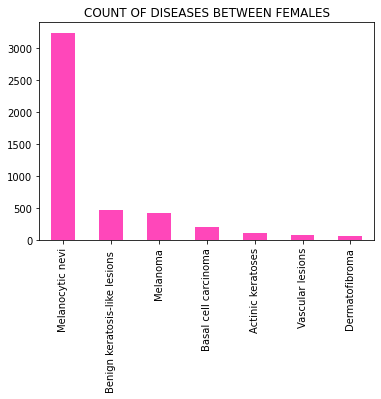

In [ ]:
#distribution of diseases b/w females

female_df = skin_df[skin_df['sex']=='female']
female_df['cell_type'].value_counts().plot(kind='bar',color = (1, 0.2, 0.7, 0.9))
plt.title('COUNT OF DISEASES BETWEEN FEMALES')
plt.show()


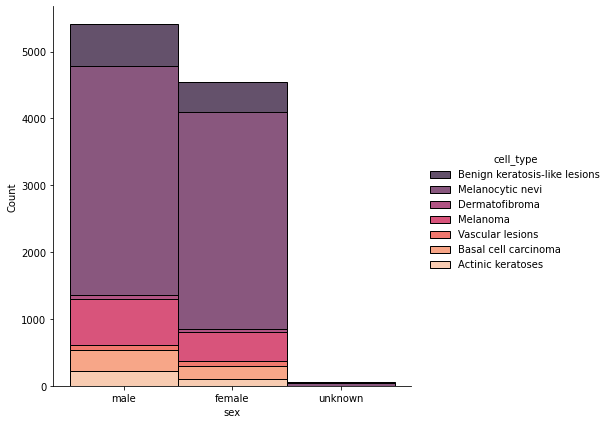

In [ ]:
ax = sns.displot(
    skin_df, x="sex",
    binwidth=10, height=6, multiple="stack", hue = 'cell_type',palette = 'rocket' 
)
plt.show()

9. How different types of diseases are treated

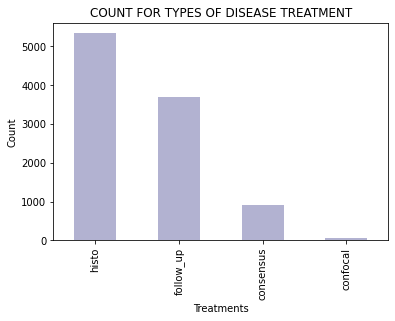

In [ ]:
#diagnosis type count

skin_df['dx_type'].value_counts().plot(kind='bar',color = (0.5, 0.5, 0.7, 0.6))
plt.title('COUNT FOR TYPES OF DISEASE TREATMENT')
plt.xlabel('Treatments')
plt.ylabel('Count')
plt.show()

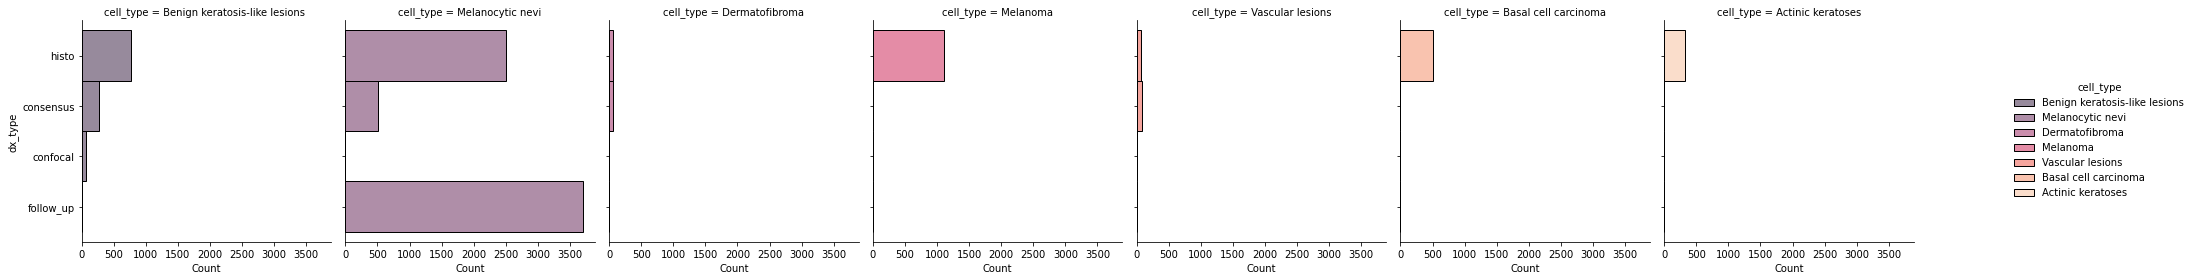

In [ ]:
ax = sns.displot(
    skin_df, y="dx_type", col="cell_type",
    binwidth=10, height=4, facet_kws=dict(margin_titles=True), hue = 'cell_type',palette = 'rocket'
)
plt.show()

#**RESIZING OF DATASET IMAGES**

In [ ]:
skin_df['image'] = skin_df['Path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000_unzipped/HAM10000_images_par...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


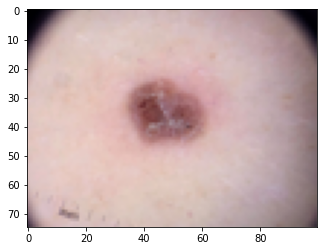

In [ ]:
plt.imshow(skin_df['image'][21])

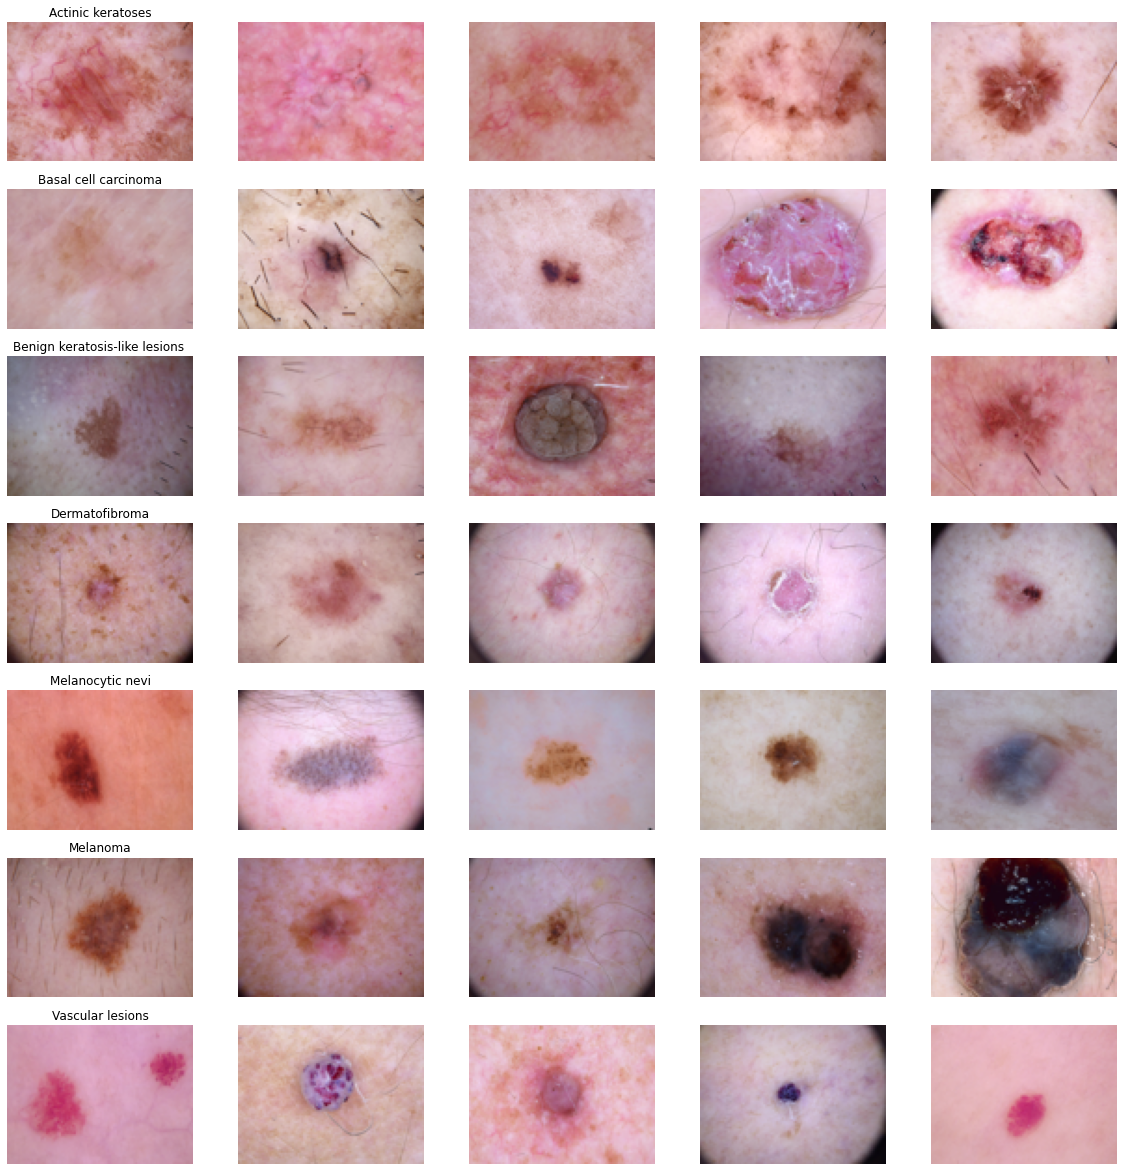

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi =300)

## **TRAIN TEST SPLIT**

In [ ]:
#var name changed -> 2

X=skin_df.drop(columns=['cell_type_idx'],axis=1)
y=skin_df['cell_type_idx']

In [ ]:
#var name changed -> 4

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20,random_state=100)

In [ ]:
X_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path,cell_type,image
1275,HAM_0006803,ISIC_0024545,mel,histo,60.0,female,abdomen,/content/HAM10000_unzipped/HAM10000_images_par...,Melanoma,"[[[241, 195, 200], [239, 187, 189], [238, 185,..."
9559,HAM_0004191,ISIC_0032562,nv,consensus,40.0,female,unknown,/content/HAM10000_unzipped/HAM10000_images_par...,Melanocytic nevi,"[[[186, 163, 169], [188, 165, 173], [208, 181,..."
5385,HAM_0001724,ISIC_0027386,nv,follow_up,45.0,male,abdomen,/content/HAM10000_unzipped/HAM10000_images_par...,Melanocytic nevi,"[[[218, 136, 148], [220, 139, 151], [222, 139,..."
3545,HAM_0004013,ISIC_0026021,nv,follow_up,35.0,female,lower extremity,/content/HAM10000_unzipped/HAM10000_images_par...,Melanocytic nevi,"[[[222, 151, 176], [222, 150, 175], [220, 147,..."
1207,HAM_0006707,ISIC_0030870,df,consensus,45.0,female,lower extremity,/content/HAM10000_unzipped/HAM10000_images_par...,Dermatofibroma,"[[[216, 165, 164], [217, 166, 165], [220, 167,..."


In [ ]:
X_test.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path,cell_type,image
8476,HAM_0001656,ISIC_0026759,nv,histo,70.0,female,lower extremity,/content/HAM10000_unzipped/HAM10000_images_par...,Melanocytic nevi,"[[[162, 121, 128], [164, 122, 129], [164, 122,..."
1679,HAM_0007086,ISIC_0033267,mel,histo,65.0,female,back,/content/HAM10000_unzipped/HAM10000_images_par...,Melanoma,"[[[162, 136, 132], [162, 138, 133], [161, 135,..."
9955,HAM_0001416,ISIC_0025427,akiec,histo,85.0,male,upper extremity,/content/HAM10000_unzipped/HAM10000_images_par...,Actinic keratoses,"[[[177, 101, 105], [181, 113, 122], [182, 113,..."
6445,HAM_0000117,ISIC_0028005,nv,follow_up,45.0,male,trunk,/content/HAM10000_unzipped/HAM10000_images_par...,Melanocytic nevi,"[[[238, 148, 144], [239, 148, 143], [242, 149,..."
2188,HAM_0000619,ISIC_0026690,mel,histo,50.0,male,lower extremity,/content/HAM10000_unzipped/HAM10000_images_par...,Melanoma,"[[[158, 146, 149], [161, 149, 151], [161, 149,..."


In [ ]:
Y_train.head()

1275    5
9559    4
5385    4
3545    4
1207    3
Name: cell_type_idx, dtype: int8

In [ ]:
Y_test.head()

8476    4
1679    5
9955    0
6445    4
2188    5
Name: cell_type_idx, dtype: int8

## **NORMALIZATION**

In [ ]:
x_train = np.asarray(X_train['image'].tolist())
x_test = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(8012,)
(2003,)


## **ONE-HOT ENCODING**

In [ ]:
# Perform one-hot encoding on the labels of training & testing set
y_train = to_categorical(Y_train, num_classes = 7)
y_test = to_categorical(Y_test, num_classes = 7)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(8012, 7)
(2003, 7)


In [ ]:
p = list(y_train)
p[:10]

[array([0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)]

In [ ]:
q = list(y_test)
q[:10]

[array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)]

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
train_x = train_x.reshape(train_x.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
val_x = val_x.reshape(val_x.shape[0], *(75, 100, 3))

In [ ]:
#train_x = train_x.reshape(90,120,3)
#x_test = train_x.reshape(x_test.shape[0],90,120,3)
#val_x = train_x.reshape(val_x.shape[0],90,120,3) 

In [ ]:
print(train_x.shape)
print(x_test.shape)
print(val_x.shape)

(7210, 75, 100, 3)
(2003, 75, 100, 3)
(802, 75, 100, 3)


In [ ]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

In [ ]:
epochs = 100 
batch_size = 10
history = model.fit(datagen.flow(train_x,train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_x, val_y),
                              verbose = 1, steps_per_epoch=train_x.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
721/721 [==============================] - 37s 35ms/step - loss: 1.0214 - accuracy: 0.6631 - val_loss: 0.8608 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 2/100
721/721 [==============================] - 23s 32ms/step - loss: 0.9195 - accuracy: 0.6703 - val_loss: 0.8602 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 3/100
721/721 [==============================] - 23s 32ms/step - loss: 0.8890 - accuracy: 0.6727 - val_loss: 0.8299 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 4/100
721/721 [==============================] - 24s 33ms/step - loss: 0.8738 - accuracy: 0.6825 - val_loss: 0.8156 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 5/100
721/721 [==============================] - 23s 32ms/step - loss: 0.8499 - accuracy: 0.6921 - val_loss: 0.7731 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 6/100
721/721 [==============================] - 23s 32ms/step - loss: 0.8274 - accuracy: 0.6940 - val_loss: 0.7564 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 7/100
721/721 [==============================]

In [ ]:
print(val_x.shape)
print(x_test.shape)

(802, 75, 100, 3)
(2003, 75, 100, 3)


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(val_x, val_y, verbose=0)
print("Validation: Accuracy = %f  ;  Loss_v = %f" % (accuracy_v, loss_v))
print("Test: Accuracy = %f  ;  Loss = %f" % (accuracy, loss))

Validation: Accuracy = 0.765586  ;  Loss_v = 0.637581
Test: Accuracy = 0.776335  ;  Loss = 0.639796


In [ ]:
# def plot_history(history):
#   acc = history.history['accuracy']
#   val_acc = history.history['val_accuracy']

#   loss = history.history['loss']
#   val_loss = history.history['val_loss']

#   f, [ax1, ax2] = plt.subplots(1,2, figsize = (15,5))
#   ax1.plot(range(len(acc)), acc, label = "acc")
#   ax1.plot(range(len(acc)), val_acc, label = "val_acc")
#   ax1.set_title("Title Accuracy vs Validation Accuracy")
#   ax1.legend()

#   ax2.plot(range(len(loss)), loss, label = "loss")
#   ax2.plot(range(len(loss)), val_loss, label = "val_loss")
#   ax2.set_title("Training Loss vs Validation Loss")
#   ax2.legend()

# plot_history(model.history)


In [ ]:
def plot_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # accuracy history
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # loss history
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


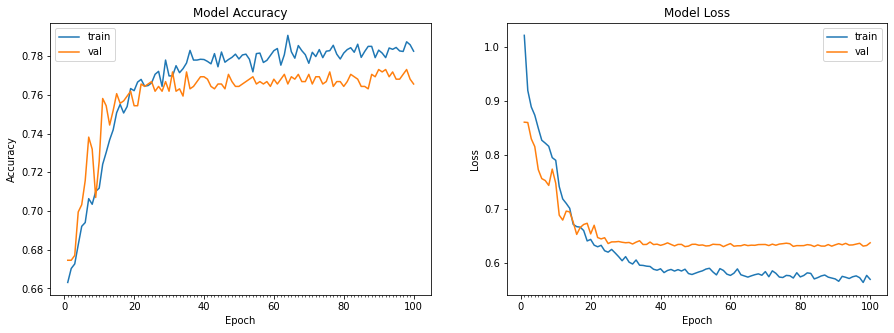

In [ ]:
plot_history(history)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model_Minor/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Model_Minor/model/assets


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

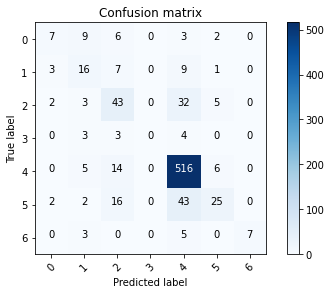

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(val_x)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(val_y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [ ]:
from keras import models
import tensorflow as tf

#tf.saved_model.save(model, '/content/drive/MyDrive/Model_Minor')


In [ ]:
model = models.load_model('/content/drive/MyDrive/Model_Minor/model')

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
image_path = '/content/drive/MyDrive/Predictions/images.jpg'

In [ ]:
img = image.load_img(image_path, target_size = (75, 100))

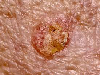

In [ ]:
img

In [ ]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis = 0)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
img_preprocessed = preprocess_input(img_batch)
img_preprocessed

array([[[[ 66.061    ,  62.221    , 105.32     ],
         [ 11.060997 ,  18.221    ,  68.32     ],
         [-32.939003 , -15.778999 ,  36.32     ],
         ...,
         [  8.060997 ,  19.221    ,  64.32     ],
         [  8.060997 ,  19.221    ,  64.32     ],
         [ -0.939003 ,  17.221    ,  65.32     ]],

        [[ 36.060997 ,  37.221    ,  79.32     ],
         [ 20.060997 ,  33.221    ,  80.32     ],
         [ -5.939003 ,  14.221001 ,  63.32     ],
         ...,
         [ 26.060997 ,  35.221    ,  80.32     ],
         [ 18.060997 ,  29.221    ,  74.32     ],
         [ 34.060997 ,  46.221    ,  89.32     ]],

        [[ -6.939003 ,   3.2210007,  46.32     ],
         [ -9.939003 ,   8.221001 ,  52.32     ],
         [-24.939003 ,  -0.7789993,  44.32     ],
         ...,
         [ 20.060997 ,  28.221    ,  73.32     ],
         [ 28.060997 ,  37.221    ,  82.32     ],
         [ 63.060997 ,  66.221    , 101.32     ]],

        ...,

        [[ -3.939003 ,   9.221001 ,  5

In [ ]:
preds = model.predict(img_preprocessed)

In [ ]:
preds

array([[0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
pred_class = np.argmax(preds, axis = -1)

In [ ]:
pred_class

array([4])

In [ ]:
ab=0
prt = lesion_class_dict[pred_class[ab]]

In [ ]:
result = str(prt)

In [ ]:
print(lesion_dict[result])

Actinic keratoses
